In [1]:
import os
import paths
import numpy as np
import pandas as pd
import geopandas as gpd

from train_model import load_data
from apollo import mechanics as ma

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.random as jr
import jax.numpy as jnp
from jaxtyping import install_import_hook
with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

import utils as ut
import optax as ox
from apollo import streamflow as strf
from apollo import metrics as me
    
key = jr.key(123)
plt.style.use(
    "https://raw.githubusercontent.com/JaxGaussianProcesses/GPJax/main/docs/examples/gpjax.mplstyle"
)
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
import tensorflow_probability.substrates.jax as tfp

from docs.examples.utils import clean_legend

import warnings
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action='ignore', category=(SettingWithCopyWarning))
plt.rc('text', usetex=False)
plt.rcParams['font.family'] = 'DeJavu Serif'

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", message="findfont: Font family")

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


### 1. Dataset

Output values are the streamflow prediction while the input, in first instance, is the precipitation.

In [13]:
station_nr = 54057

df = pd.read_csv('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_gdf.csv'))
name = df.loc[df.index[3]].iloc[2]
print('Processing site "', name, '"')
    
boundary = gpd.read_file('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '.shp'))
    
rf = load_data.load_data('../' + paths.CATCHMENT_BASINS + '/' + str(station_nr) + '/' + str(str(station_nr) + '_lumped_9to9.csv'), verbose=False)

Processing site " Severn at Haw Bridge "


In [14]:
days = 4
features = (['Rain'] + ['Rain-' + f'{d+1}' for d in range(days)] \
        + ['Rain_28_Mu','Rain_90_Mu','Rain_180_Mu', 'Temperature_28_Mu','Temperature_90_Mu','Temperature_180_Mu']
            + ['Temperature'] + ['Temperature-' + f'{d+1}' for d in range(days)])
            #+ ['Resultant Windspeed'] \
            #+ ['Resultant Windspeed-' + f'{d+1}' for d in range(days)] \
            #+ ['Humidity'] + ['Humidity-' + f'{d+1}' for d in range(days)] \
            #"+ ['Soil Moisture ' + f'{i+1}' for i in range(4)]

In [15]:
import importlib
importlib.reload(load_data)

<module 'train_model.load_data' from 'C:\\Users\\aline\\soil-moisture-proxies\\train_model\\load_data.py'>

In [16]:
years_eval = [2010 + i for i in range(12)]
#years_train = [1982,1983, 1991,1993,1997,2000]
years_train = [1982,1983, 1985, 1989, 1991,1993,1994,1997,2000]

# LOAD DATA
testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
trnset, full_set = load_data.preprocess_data(rf, features, years_eval, years_train)
print(len(trnset))
targets = ['Flow']
xspace = ma.featurelocator(rf, features)
yspace = ma.featurelocator(rf, targets)

# TRAINING
x_train = load_data.reshape_input(trnset, xspace)
y_train = load_data.reshape_output(trnset, yspace)
y_full = load_data.reshape_input(full_set, xspace)

# Keep test set always the same
test_set = full_set[-len(testrf):, :]

y_scaler = StandardScaler().fit(y_train)
standardised_train_y = y_scaler.transform(y_train)

# Select 2500 random samples
indices = np.random.permutation(len(x_train))
x_train_random = x_train[indices[:1000]]
standardised_train_y_random = standardised_train_y[indices[:1000]]

# Turn it into a GPJax Dataset
D = gpx.Dataset(X=jnp.array(x_train, dtype=jnp.float64), y=jnp.array(standardised_train_y, dtype=jnp.float64))
        
xtest = load_data.reshape_input(test_set, xspace)
ytest = load_data.reshape_output(test_set, yspace)
standardised_test_y = y_scaler.transform(ytest)

xfull = load_data.reshape_input(full_set, xspace)
yfull = load_data.reshape_output(full_set, yspace)
standardised_full_y = y_scaler.transform(yfull)

3286


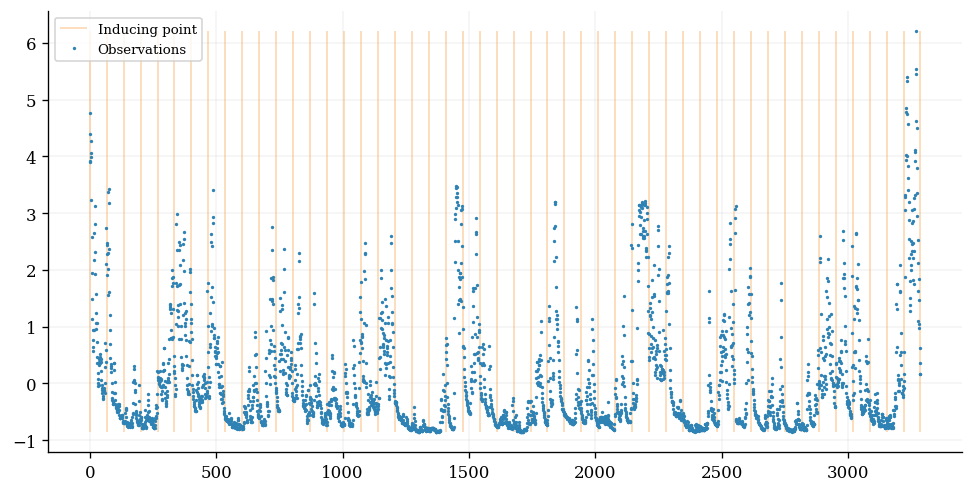

In [17]:
x_indices = np.arange(x_train.shape[0])

z = jnp.linspace(x_indices.min(), x_indices.max(), 50).reshape(-1, 1)

fig, ax = plt.subplots(figsize=(8,4))
ax.vlines(
    z,
    ymin=standardised_train_y.min(),
    ymax=standardised_train_y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)

ax.plot(x_indices, standardised_train_y, "o", label="Observations", color=cols[0], markersize=1)
#ax.plot(x_train, y_train, label="Latent function", color=cols[1])
ax.legend(loc="best")
plt.show()

### 2. Prior

In [18]:
tfb = tfp.bijectors

prior_lengthscales = [2.02,1.37,1.21,1.65,2.22,0.63,0.17,0.45,0.19,0.08,0.05,8.87,7.1,3.85,7.74,4.14]
lengthscale_array = jnp.array(prior_lengthscales, dtype=jnp.float64)
print(len(prior_lengthscales))

kernel_Matern = gpx.kernels.Matern32(active_dims=np.arange(16).tolist(), lengthscale=lengthscale_array, variance=0.61)
kernel_Matern = kernel_Matern.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-5, dtype=jnp.float64)))
kernel_Matern = kernel_Matern.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e4, dtype=jnp.float64)))

kernel_Linear = gpx.kernels.Linear(active_dims=np.arange(16).tolist(), variance=0.79) #active_dims=np.arange(len(features)).tolist()
kernel_Linear = kernel_Linear.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e4, dtype=jnp.float64)))

kernel = gpx.kernels.ProductKernel(kernels=[kernel_Matern, kernel_Linear])

meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

16


In [19]:
# Prior distribution is the distribution without extra knowledge
xtest_oneyear = xtest[:365]
prior_dist = prior.predict(xtest_oneyear)

# Distillate the mean and variance to be able to sample functions
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(5,))
samples

Array([[ 0.28368693,  0.08214678,  0.08132842, ..., -0.66071068,
        -0.67915437, -0.35353258],
       [-0.08835034, -0.73480727, -0.84817471, ...,  0.96758096,
         0.70277345,  0.32636726],
       [ 0.23810684,  0.22398574,  0.50683099, ..., -0.10200185,
         0.22124232,  0.10952461],
       [ 0.50591169,  0.73386166,  0.0860441 , ...,  0.20092871,
         0.18789549,  0.32775309],
       [-0.64953727, -0.53823781, -0.68892526, ..., -0.22168803,
         0.41544447,  0.2243808 ]], dtype=float64)

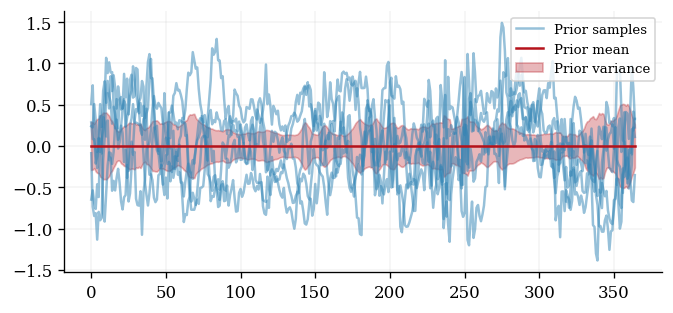

In [20]:
fig, ax = plt.subplots()
ax.plot(np.arange(xtest_oneyear.shape[0]), samples.T, alpha=0.5, color=cols[0], label="Prior samples")
ax.plot(np.arange(xtest_oneyear.shape[0]), prior_mean, color=cols[1], label="Prior mean")
ax.fill_between(
    np.arange(xtest_oneyear.shape[0]),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    color=cols[1],
    label="Prior variance",
)
ax.legend(loc="best")
ax = clean_legend(ax)

### 3. Posterior

In [21]:
# DUMMY DATASET
'''
X_train = np.random.randn(1000, 10)  # 1000 data points, 10 features
Y_train = np.sin(X_train[:, 0:1]) + np.random.randn(1000, 1) * 0.05
D = gpx.Dataset(X=X_train, y=Y_train)

xtest = np.random.randn(500, 10) 
'''

'\nX_train = np.random.randn(1000, 10)  # 1000 data points, 10 features\nY_train = np.sin(X_train[:, 0:1]) + np.random.randn(1000, 1) * 0.05\nD = gpx.Dataset(X=X_train, y=Y_train)\n\nxtest = np.random.randn(500, 10) \n'

In [22]:
# Choice for the value of obs_stddev
likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=jnp.array([1.0], dtype=jnp.float64)) 
likelihood = likelihood.replace_bijector(obs_stddev=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))

posterior = prior * likelihood

### 3b. Introduction Sparse Stochastic Variational Inference

In [2]:
n = 50000
noise = 0.2

key, subkey = jr.split(key)
x = jr.uniform(key=key, minval=-5.0, maxval=5.0, shape=(n,)).reshape(-1, 1)
f = lambda x: jnp.sin(4 * x) + jnp.cos(2 * x)
signal = f(x)
y = signal + jr.normal(subkey, shape=signal.shape) * noise
D = gpx.Dataset(X=x, y=y)

xtest = jnp.linspace(-5.5, 5.5, 500).reshape(-1, 1)

[Text(0.5, 0, '$x$'), Text(0, 0.5, '$f(x)$')]

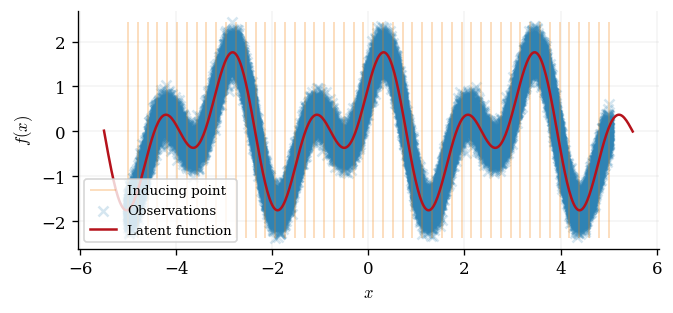

In [3]:
z = jnp.linspace(-5.0, 5.0, 50).reshape(-1, 1)

fig, ax = plt.subplots()
ax.vlines(
    z,
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)
ax.scatter(x, y, alpha=0.2, color=cols[0], label="Observations")
ax.plot(xtest, f(xtest), color=cols[1], label="Latent function")
ax.legend()
ax.set(xlabel=r"$x$", ylabel=r"$f(x)$")

In [4]:
meanf = gpx.mean_functions.Zero()
likelihood = gpx.likelihoods.Gaussian(num_datapoints=n)
prior = gpx.gps.Prior(mean_function=meanf, kernel=gpx.kernels.RBF())
posterior = prior * likelihood

In [23]:
num_inducing_points = 1500
num_dimensions = len(features)
inducing_points = [jnp.linspace(x_indices.min(), x_indices.max(), num_inducing_points) for i in range(num_dimensions)]
z = jnp.stack(inducing_points, axis=-1)
q = gpx.variational_families.VariationalGaussian(posterior=posterior, inducing_inputs=z)

In [24]:
negative_elbo = gpx.objectives.ELBO(negative=True)
negative_elbo = jit(negative_elbo)

In [ ]:
schedule = ox.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=0.01,
    warmup_steps=75,
    decay_steps=1500,
    end_value=0.001,
)

opt_posterior, history = gpx.fit(
    model=q,
    objective=negative_elbo,
    train_data=D,
    optim=ox.adam(learning_rate=schedule),
    num_iters=3000,
    key=jr.key(42),
    batch_size=128,
)

  0%|          | 0/3000 [00:00<?, ?it/s]

In [ ]:
latent_dist = opt_posterior(xtest)
predictive_dist = opt_posterior.posterior.likelihood(latent_dist)

meanf = predictive_dist.mean()
sigma = predictive_dist.stddev()

fig, ax = plt.subplots()
ax.scatter(x, y, alpha=0.15, label="Training Data", color=cols[0])
ax.plot(xtest, meanf, label="Posterior mean", color=cols[1])
ax.fill_between(
    xtest.flatten(),
    meanf - 2 * sigma,
    meanf + 2 * sigma,
    alpha=0.3,
    color=cols[1],
    label="Two sigma",
)
ax.vlines(
    opt_posterior.inducing_inputs,
    ymin=y.min(),
    ymax=y.max(),
    alpha=0.3,
    linewidth=1,
    label="Inducing point",
    color=cols[2],
)
ax.legend()

### 4. Parameters

In [56]:
%%time
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
#negative_mll(posterior, train_data=D)
negative_mll = jit(negative_mll)

opt_posterior, history = gpx.fit_scipy(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    max_iters=1000,
)

print(opt_posterior.prior)
print(opt_posterior.likelihood)

C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
C:\Users\aline\AppData\Local\Programs\Python\Python310\lib\site-packages\cola\backends\backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


KeyboardInterrupt: 

In [65]:
def predict_in_batches(model, xtest, train_data, batch_size=500):
    n = xtest.shape[0]
    predictive_means = []
    predictive_stds = []

    for start in range(0, n, batch_size):
        end = min(start + batch_size, n)
        xtest_batch = xtest[start:end]

        # Perform prediction on the current batch
       # latent_dist = model.predict(xtest_batch, train_data=train_data)
       # predictive_dist = model.likelihood(latent_dist)
        
        latent_dist = model(xtest_batch)
        predictive_dist = model.posterior.likelihood(latent_dist)

        # Collect the means and standard deviations
        predictive_means.append(predictive_dist.mean().reshape(-1, 1))
        predictive_stds.append(predictive_dist.stddev().reshape(-1, 1))

    # Concatenate all the results
    predictive_mean = np.concatenate(predictive_means, axis=0)
    predictive_std = np.concatenate(predictive_stds, axis=0)

    return predictive_mean, predictive_std

In [66]:
batch_size = 500
predictive_mean, predictive_std = predict_in_batches(opt_posterior, xtest, train_data=D, batch_size=batch_size)

In [67]:
'''
latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean().reshape(-1, 1)
predictive_std = predictive_dist.stddev().reshape(-1, 1)
'''

'\nlatent_dist = opt_posterior.predict(xtest, train_data=D)\npredictive_dist = opt_posterior.likelihood(latent_dist)\n\npredictive_mean = predictive_dist.mean().reshape(-1, 1)\npredictive_std = predictive_dist.stddev().reshape(-1, 1)\n'

In [68]:
if rf['Date'].dtype == 'float64':
    rf['Date'] = pd.to_datetime(rf['Date'], unit='s').dt.date
testrf = rf[pd.to_datetime(rf['Date']).dt.year.isin(years_eval)]
testrf['Predicted'] = y_scaler.inverse_transform(predictive_mean)

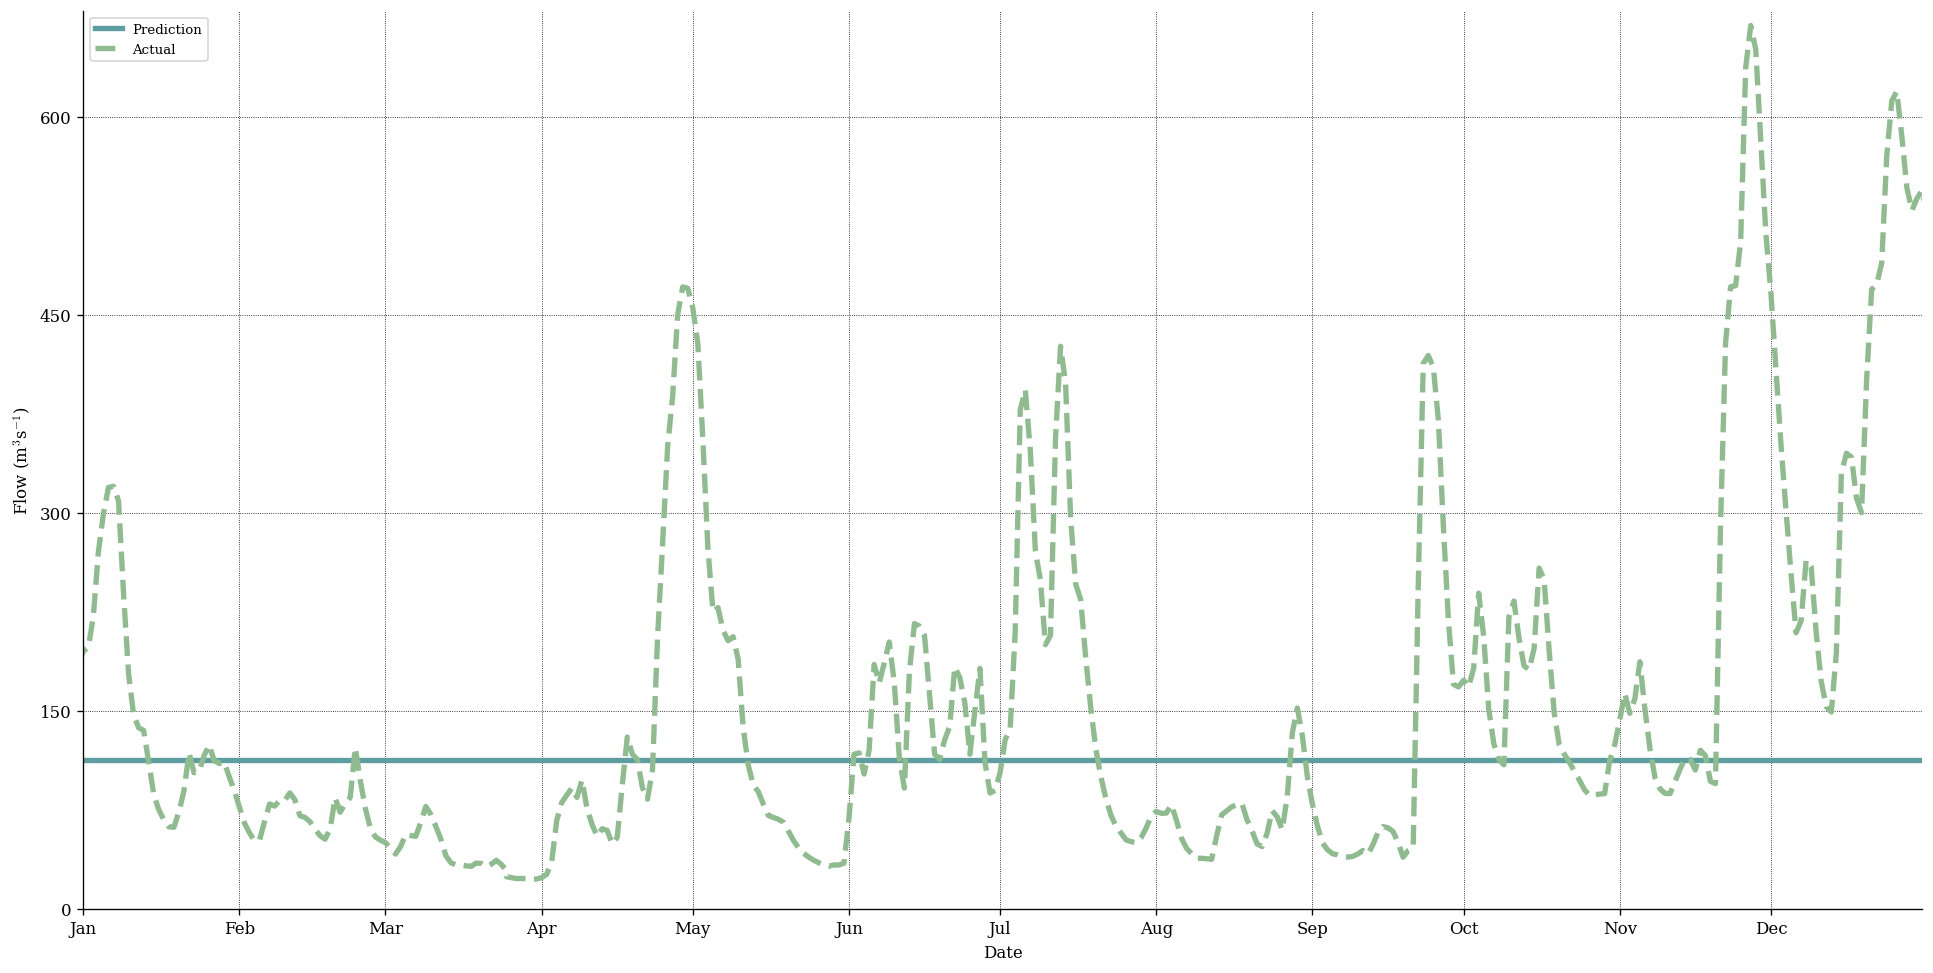

In [69]:
maxflow=680
strf.year_plot(maxflow, testrf, 'Predicted', 'Flow', 2012)

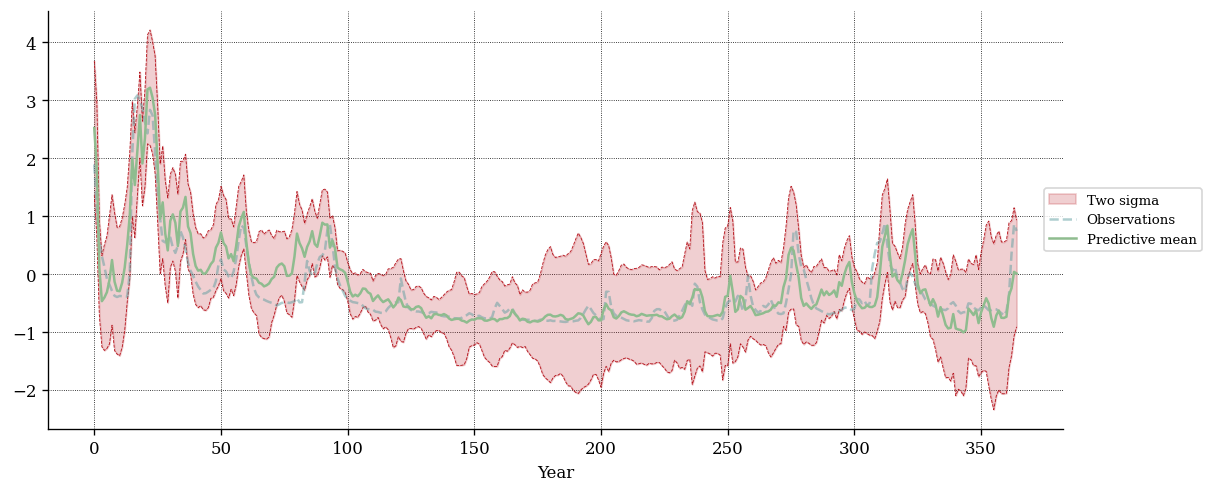

In [18]:
def plot_gp_results(x_train, xtest, y_train, y_test, pred_mean, pred_std=None, plot_train_data=False, plot_confidence=True, colour1='cadetblue', colour2='darkseagreen'):

    fig, ax = plt.subplots(figsize=(10, 4))

    len_Xtrain = x_train.shape[0]
    len_Xtest = xtest.shape[0]
    len_Xtrain=0

    if plot_train_data is True:
        ax.plot(np.arange(len_Xtrain), y_train, "x", label="Observations", color=cols[0], alpha=0.5, markersize=1)
    if plot_confidence is True:
        ax.fill_between(
            np.arange(len_Xtrain, len_Xtrain + len_Xtest),
            pred_mean.squeeze() - 2 * pred_std.squeeze(),
            pred_mean.squeeze() + 2 * pred_std.squeeze(),
            alpha=0.2,
            label="Two sigma",
            color=cols[1],
        )
        ax.plot(
            np.arange(len_Xtrain, len_Xtrain + len_Xtest),
            pred_mean - 2 * pred_std,
            linestyle="--",
            linewidth=0.5,
            color=cols[1],
        )
        ax.plot(
            np.arange(len_Xtrain, len_Xtrain + len_Xtest),
            pred_mean + 2 * pred_std,
            linestyle="--",
            linewidth=0.5,
            color=cols[1],
        )
    ax.plot(
        np.arange(len_Xtrain, len_Xtrain + len_Xtest), y_test, label="Observations", color=colour1, alpha=0.5, lw=1.5, ls='--'
    )    
    ax.plot(np.arange(len_Xtrain, len_Xtrain + len_Xtest), pred_mean, label="Predictive mean", color=colour2, lw=1.5)
    ax.set_xlabel("Year")
    ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))
    ax.grid(c='black', ls='dotted', lw=0.5)
    
plot_gp_results(x_train, xtest[:365], standardised_train_y, standardised_test_y[:365], predictive_mean[:365], predictive_std[:365])

In [19]:
print(yfull.shape)

(15009, 1)


(4260,)


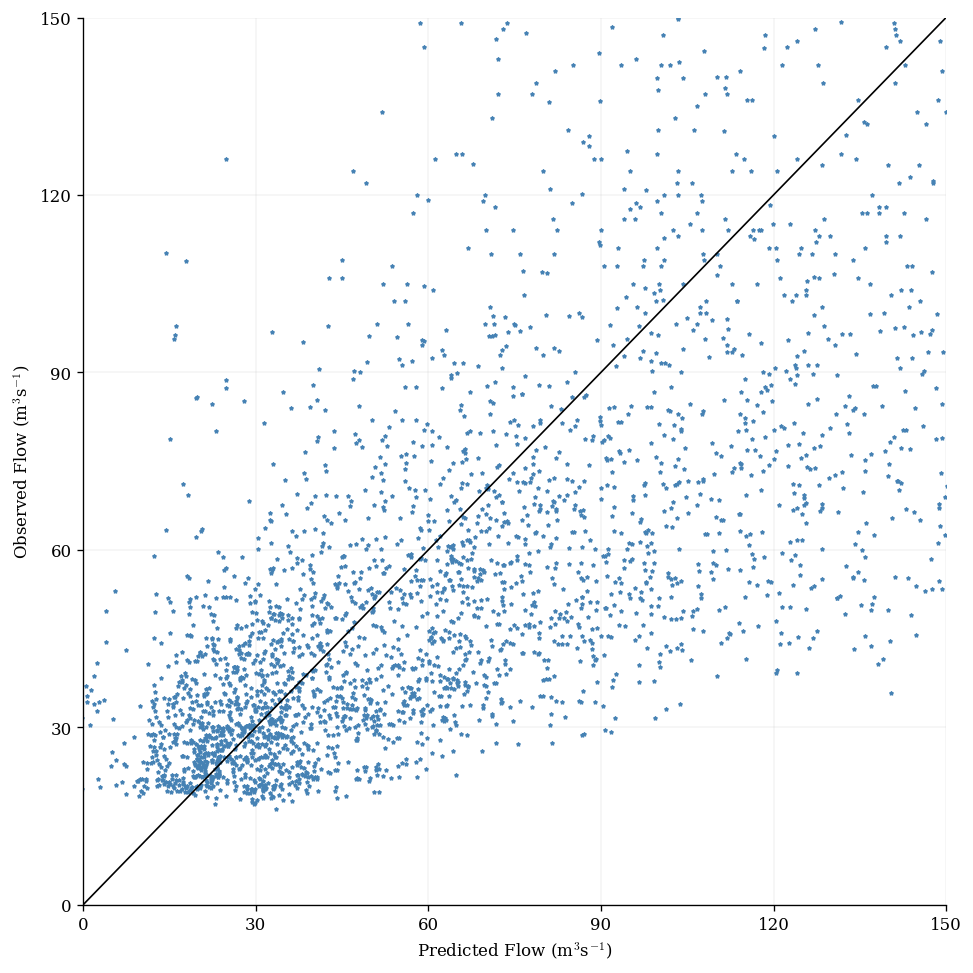

- - - - - - - - - - - - - - -
RMSE: 69.74560524509864
NSE: 0.6844000640853787
RE: 0.9061095156666829


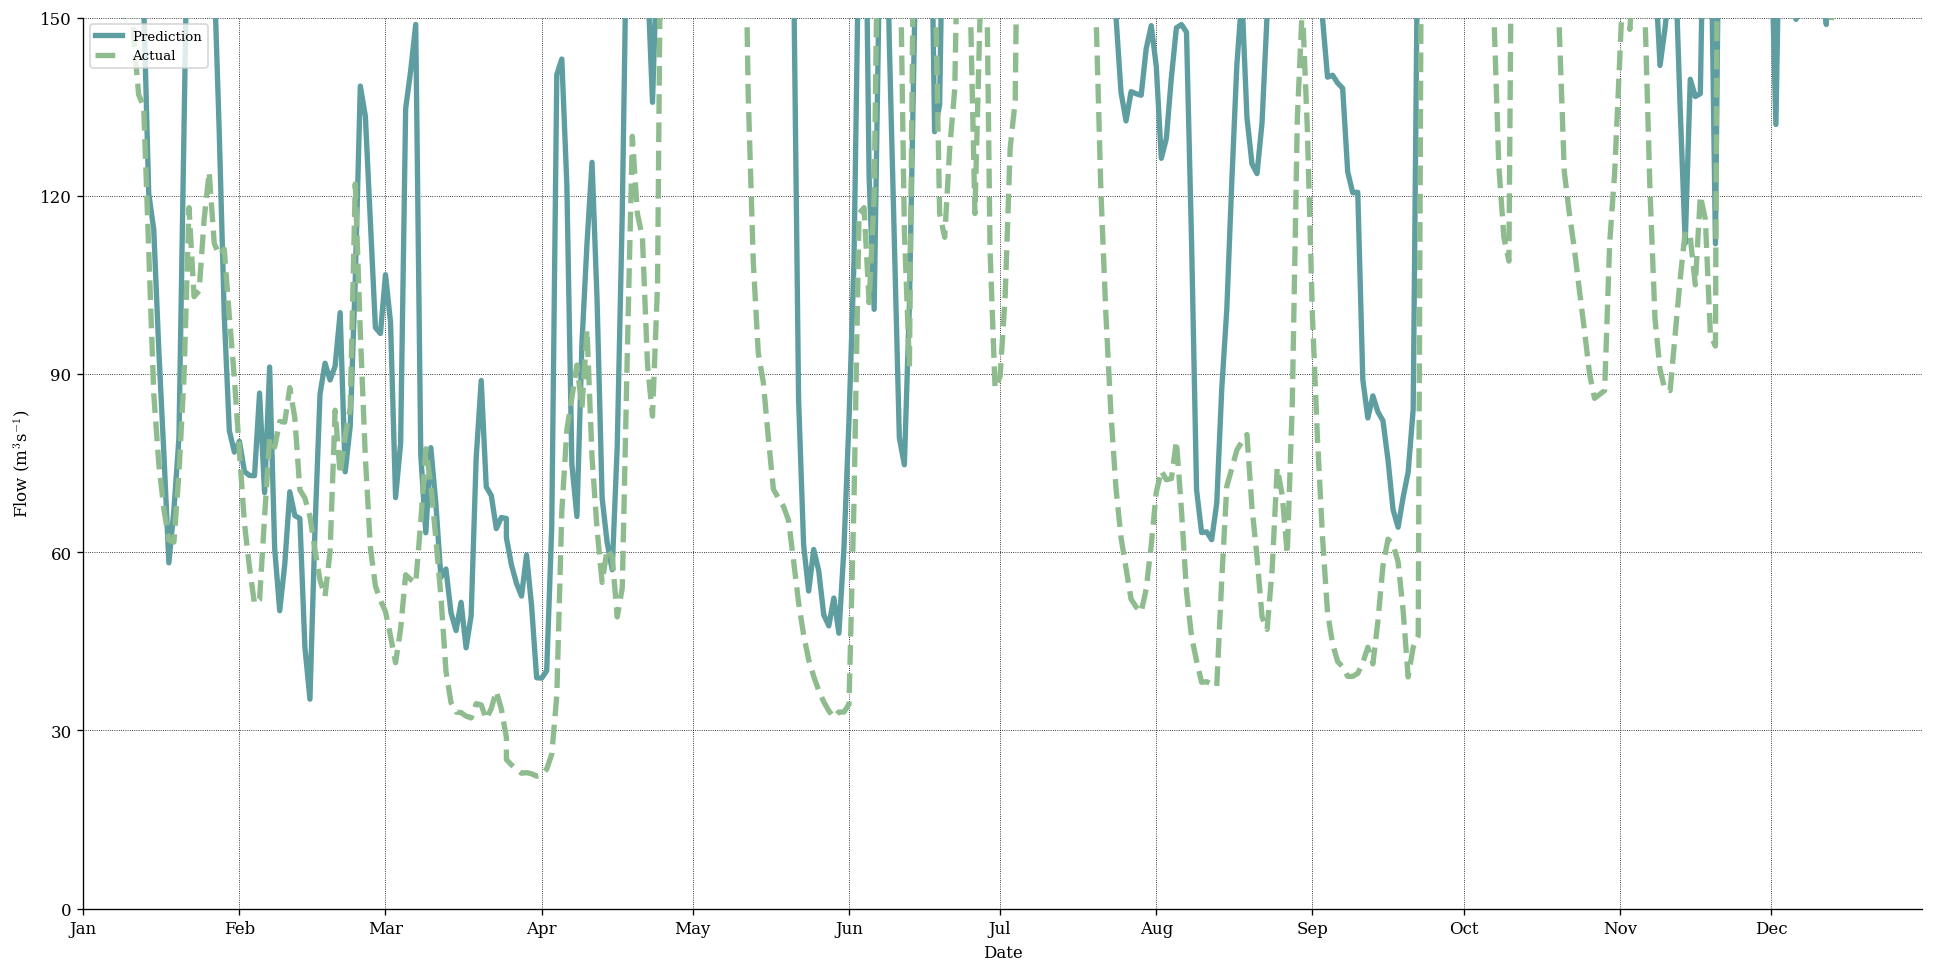

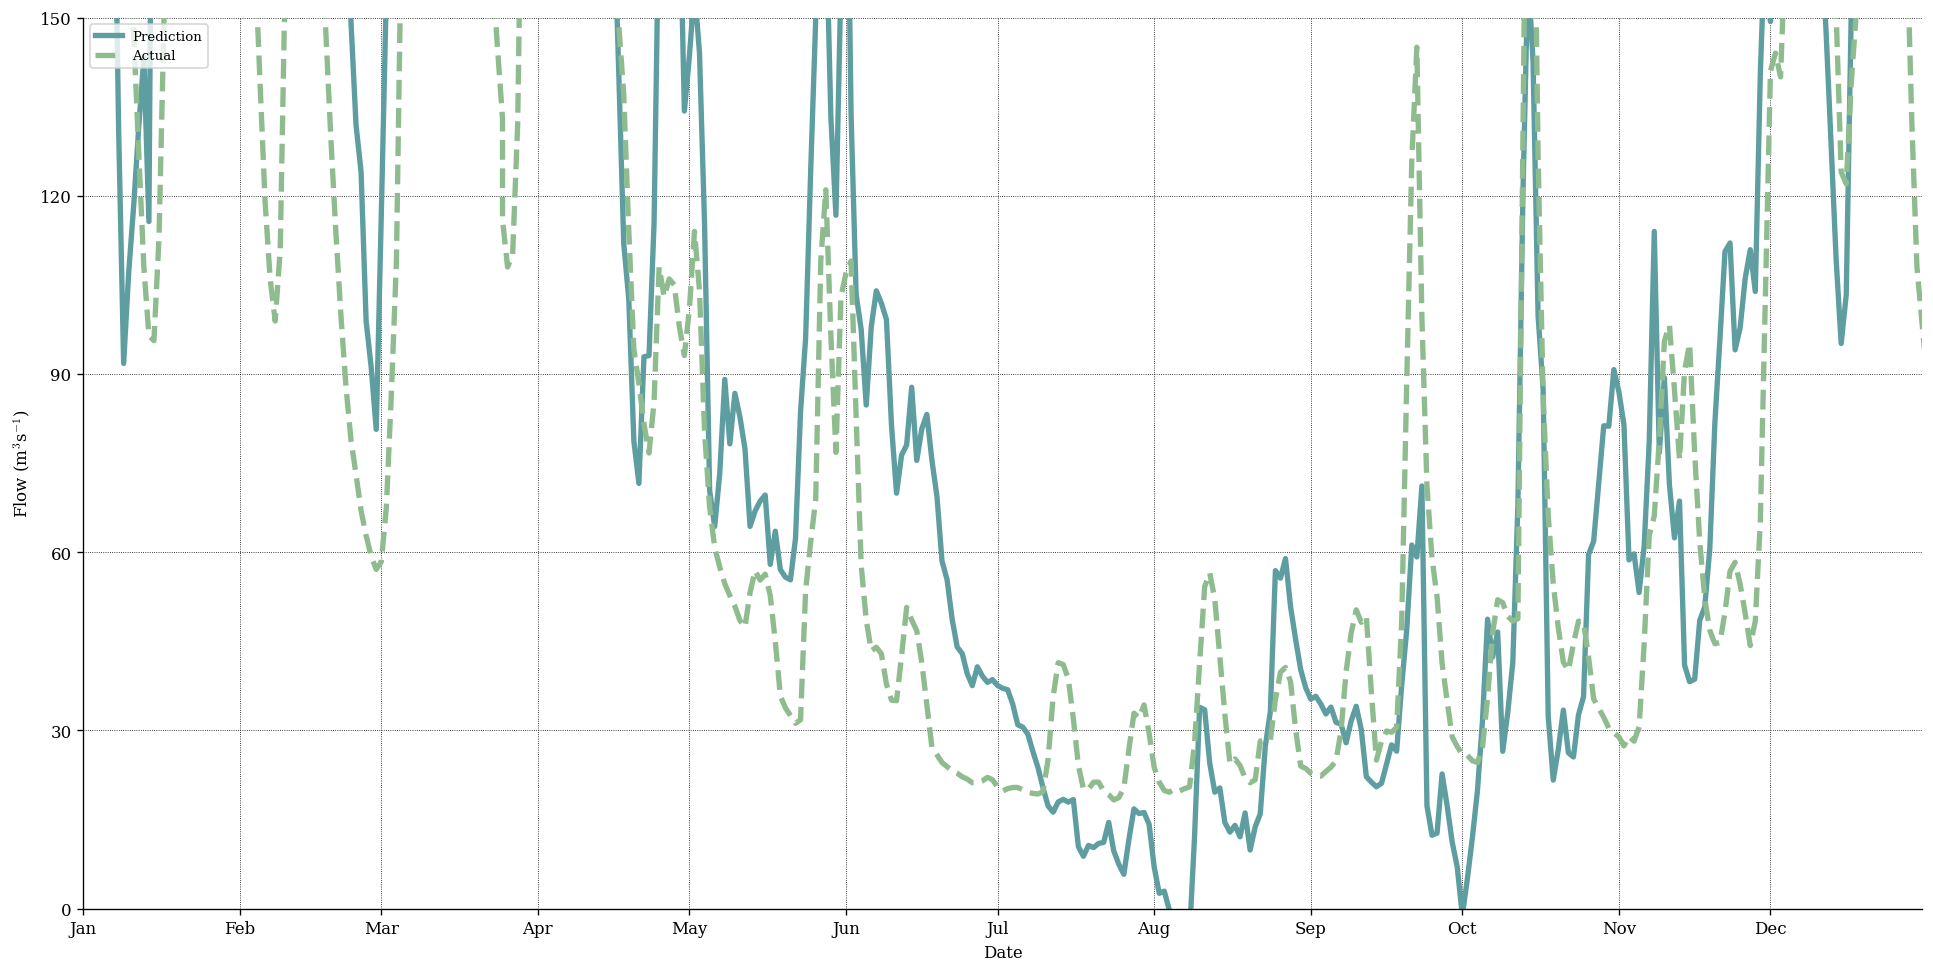

In [20]:
maxflow = 150

# recalculate PSI for alpha=1 and beta=1
psi_RE = ut.psi_distribution(yfull, 'gamma')

for df in [testrf]:

    psi_df = psi_RE[-len(ytest):].squeeze()
    print(psi_df.shape)
    
    strf.scatter_plot(maxflow, df, 'Predicted', 'Flow')
    print('- - - - - - - - - - - - - - -')
    print('RMSE: ' + str(me.RMSE(df['Flow'], df['Predicted'])))
    print('NSE: ' + str(me.R2(df['Flow'], df['Predicted'])))
    print('RE: ' + str(me.RE(df['Flow'], df['Predicted'], psi_df)))
#strf.year_plot(maxflow, rf, 'Predicted', 'Flow', 2007)
strf.year_plot(maxflow, testrf, 'Predicted', 'Flow', 2012)  
strf.year_plot(maxflow, testrf, 'Predicted', 'Flow', 2018)  

In [ ]:
"""
Code below, important things for stability include: the “replace_bijector” lines (they constrain the kernel params to stop them doing silly things), and making sure that you have the JAX-specific line from the first cell of the regression notebook included, bcus if u don’t use float64 numbers, it all breaks
"""
 
class GP_regressor():

    def __init__(self, GP_params = None, tune_hypers = True):

        self.tune_hypers = tune_hypers
        if GP_params is not None:
            self.kernel = GP_params['kernel']
            self.mean_function = GP_params['mean_function']
            self.multiinput = GP_params['multiinput']

        else:
            self.kernel = gpx.kernels.RBF()
            self.mean_function = gpx.mean_functions.Zero()
            self.multiinput = False

        # constrain lengthscales (exact constraint tbd)
        self.kernel = self.kernel.replace_bijector(lengthscale=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))#, high=jnp.array(3e1, dtype=jnp.float64)))
        self.kernel = self.kernel.replace_bijector(variance=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64), high=jnp.array(1e1, dtype=jnp.float64)))

        self.prior = gpx.gps.Prior(mean_function=self.mean_function, kernel=self.kernel)
        return None

   
    def fit(self, X_train, Y_train):
        self.n_samples_train = X_train.shape[0]
        self.n_features = X_train.shape[1]
        Y_train = Y_train.reshape(-1, 1)
        self.n_targets = Y_train.shape[1]

    # check statistics
    # print(f'x_train: mean = {np.mean(X_train, axis = 0)}, std = {np.std(X_train, axis = 0)}')
    # print(f'y_train: mean = {np.mean(Y_train)}, std = {np.std(Y_train)}')
    # for i, PC in enumerate(X_train.T):
    #       print(PC.shape)
    #       plt.figure()
    #       plt.hist(PC)
    #       plt.show()

        self.D = gpx.Dataset(X=jnp.array(X_train, dtype=jnp.float64), y=jnp.array(Y_train, dtype=jnp.float64))
        
        likelihood = gpx.likelihoods.Gaussian(num_datapoints=self.D.n, obs_stddev=jnp.array([1.0], dtype=jnp.float64)) # here i choose the value of obs_stddev
        likelihood = likelihood.replace_bijector(obs_stddev=tfb.SoftClip(low=jnp.array(1e-3, dtype=jnp.float64)))

        posterior = self.prior * likelihood

        if self.tune_hypers:
            negative_mll = gpx.objectives.ConjugateMLL(negative=True)
            negative_mll = jit(negative_mll)

            # hyperparam tuning
            print(likelihood.obs_stddev)
            print(likelihood.obs_stddev.dtype)
            self.opt_posterior, self.history = gpx.fit_scipy(model=posterior, objective=negative_mll, train_data=self.D, max_iters=1000)

            # print(dir(self.opt_posterior))
            # print(self.history)
            print(self.opt_posterior.prior)
            print(self.opt_posterior.likelihood)

        else:
            self.opt_posterior = posterior

 #and then opt_posterior is the thing that u use for the predictions